# 对数

In [1]:
import torch

logn = torch.log(torch.tensor(2048.0)) / torch.log(torch.tensor(256.0))
logn = torch.max(torch.tensor(1.0), logn)
print(logn)

print(torch.exp(logn * 1.114514))

tensor(1.3750)
tensor(4.6295)


# 注意力

In [2]:
import torch
import math

Batch = 1
Seq_len = 4
D_model = 8
Q = torch.tensor([[[1, 2, 3, 4, 5, 6, 7, 8],
                    [8, 7, 6, 5, 4, 3, 2, 1],
                    [1, 3, 5, 7, 2, 4, 6, 8],
                    [8, 6, 4, 2, 7, 5, 3, 1]]],
                    dtype=torch.float32)
K = Q
V = Q
print(f"Q: \n{Q}")
print(f"K: \n{K}")
print(f"V: \n{V}")
print("\n")

# 1. 计算 Q 和 K 的点积 Q matmul K
dot_product = torch.matmul(Q, K.transpose(-2, -1))
print(f"Q matmul K: \n{dot_product}")
print("\n")

# 2. 将点积除以 sqrt(dk)
dk = math.sqrt(Q.size(-1))
dot_product = dot_product / dk
print(f"Q matmul K / sqrt(dk): \n{dot_product}")
print("\n")

# 3. mask
mask = torch.ones(Q.size(-2), K.size(-2), dtype=torch.bool).tril(diagonal=0)
dot_product = dot_product.masked_fill(mask.logical_not(), float('-inf'))
print(f"mask: \n{mask}")
print(f"Q matmul K / sqrt(dk) with mask: \n{dot_product}")
print("\n")

# 4. softmax
attention_scores = torch.nn.functional.softmax(dot_product, dim=-1)
print(f"softmax: \n{attention_scores}")
print("\n")

# 5. attention_weights matmul V
output = torch.matmul(attention_scores, V)
print(f"attention_weights matmul V: \n{output}")

Q: 
tensor([[[1., 2., 3., 4., 5., 6., 7., 8.],
         [8., 7., 6., 5., 4., 3., 2., 1.],
         [1., 3., 5., 7., 2., 4., 6., 8.],
         [8., 6., 4., 2., 7., 5., 3., 1.]]])
K: 
tensor([[[1., 2., 3., 4., 5., 6., 7., 8.],
         [8., 7., 6., 5., 4., 3., 2., 1.],
         [1., 3., 5., 7., 2., 4., 6., 8.],
         [8., 6., 4., 2., 7., 5., 3., 1.]]])
V: 
tensor([[[1., 2., 3., 4., 5., 6., 7., 8.],
         [8., 7., 6., 5., 4., 3., 2., 1.],
         [1., 3., 5., 7., 2., 4., 6., 8.],
         [8., 6., 4., 2., 7., 5., 3., 1.]]])


Q matmul K: 
tensor([[[204., 120., 190., 134.],
         [120., 204., 134., 190.],
         [190., 134., 204., 120.],
         [134., 190., 120., 204.]]])


Q matmul K / sqrt(dk): 
tensor([[[72.1249, 42.4264, 67.1751, 47.3762],
         [42.4264, 72.1249, 47.3762, 67.1751],
         [67.1751, 47.3762, 72.1249, 42.4264],
         [47.3762, 67.1751, 42.4264, 72.1249]]])


mask: 
tensor([[ True, False, False, False],
        [ True,  True, False, False],
        

# 对数位置编码权重-对数一维卷积

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

12345
123456
1234567
12345678

class LogConv1d(nn.Conv1d):
    """
    高频外推、低频内插, 对数卷积核权重: 调整卷积核的权重, 使其随着位置的增加而逐渐变化, 模拟对数位置编码的效果.
    """
    def __init__(self, in_channels, out_channels, bias, kernel_size, groups, padding, log_scale_init=0.1):
        super().__init__(in_channels, out_channels, kernel_size, groups=groups, padding=padding, bias=bias)
        self.log_scale = nn.Parameter(torch.tensor(log_scale_init))
    
    def forward(
        self, 
        input: torch.Tensor
    ) -> torch.Tensor:
        # 获取卷积核的权重
        weight = self.weight # [out_channels,                                                                                    in_channels, kernel_size]
        offset = 64
        # 获取out_channels
        out_channels = weight.size(0)
        # 计算logn
        logn = torch.arange(offset+1, offset+out_channels+1, dtype=torch.float32, device=input.device)[-out_channels:] # [out_channels]
        # base 是训练的最大序列长度
        base = torch.tensor(256).to(input.device)
        logn = torch.log(logn) / torch.log(base)
        logn[logn < 1.0] = 1.0 # 使logn的值在1附近
        logn = logn.to(input.dtype).view(out_channels, 1, 1)
        # 对卷积核的权重进行调整
        weight = weight * torch.exp(self.log_scale * logn) # exp(log_scale * logn

        # 计算卷积
        return F.conv1d(input, weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
    

# 梯度计算
input = torch.randn(1, 8, 256)
input.requires_grad = True
log_conv1d = LogConv1d(8, 8, True, 3, 1, 1)
output = log_conv1d(input)
output.mean().backward()
print(input.grad)
print(log_conv1d.log_scale.grad)
print(log_conv1d.weight.grad)

tensor([[[ 2.2767e-04,  8.5741e-05,  8.5741e-05,  ...,  8.5741e-05,
           8.5741e-05, -2.2239e-04],
         [ 2.0852e-04,  2.3017e-04,  2.3017e-04,  ...,  2.3017e-04,
           2.3017e-04, -1.6156e-04],
         [ 4.7242e-04,  5.3138e-04,  5.3138e-04,  ...,  5.3138e-04,
           5.3138e-04,  3.3869e-04],
         ...,
         [-3.7948e-04, -3.6988e-04, -3.6988e-04,  ..., -3.6988e-04,
          -3.6988e-04, -2.6594e-04],
         [-2.0685e-04, -4.3018e-04, -4.3018e-04,  ..., -4.3018e-04,
          -4.3018e-04, -3.3230e-04],
         [-1.6219e-05, -2.0170e-04, -2.0170e-04,  ..., -2.0170e-04,
          -2.0170e-04, -2.5442e-04]]])
tensor(-0.0155)
tensor([[[ 0.0073,  0.0075,  0.0080],
         [-0.0141, -0.0140, -0.0144],
         [-0.0108, -0.0106, -0.0097],
         [-0.0017, -0.0018, -0.0021],
         [-0.0022, -0.0021, -0.0019],
         [-0.0023, -0.0022, -0.0015],
         [-0.0022, -0.0021, -0.0019],
         [ 0.0128,  0.0134,  0.0129]],

        [[ 0.0073,  0.0075,  0.0

# 多模态内聚门控多层感知机

In [4]:
import torch

# 假设我们有三个模态经过Mamba后的hidden states
batch_size = 2
seq_len = 4
hidden_size = 8
Ax = torch.randn(batch_size, seq_len, hidden_size)
Bx = torch.randn(batch_size, seq_len, hidden_size)
Cx = torch.randn(batch_size, seq_len, hidden_size)
print(f"Ax: {Ax.shape}, Bx: {Bx.shape}, Cx: {Cx.shape}")

class MLP(torch.nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.ffn_hidden_size = hidden_size * 4

        self.gate_linear = torch.nn.Linear(self.hidden_size, self.ffn_hidden_size)
        self.up_linear = torch.nn.Linear(self.hidden_size, self.ffn_hidden_size)
        self.act = torch.nn.SiLU()
        self.down_linear = torch.nn.Linear(self.ffn_hidden_size, self.hidden_size)

    def forward(self, x):
        return self.down_linear(self.act(self.up_linear(x) * self.gate_linear(x)))

class SharedMLP(torch.nn.Module):
    def __init__(self, hidden_size, shared_up_linear):
        super(SharedMLP, self).__init__()
        self.hidden_size = hidden_size
        self.ffn_hidden_size = hidden_size * 4

        self.gate_linear = torch.nn.Linear(self.hidden_size, self.ffn_hidden_size)
        self.up_linear = shared_up_linear
        self.act = torch.nn.SiLU()
        self.down_linear = torch.nn.Linear(self.ffn_hidden_size, self.hidden_size)

    def forward(self, x):
        return self.down_linear(self.act(self.up_linear(x) * self.gate_linear(x)))

class CohesiveCrossDomainMixturesofExperts(torch.nn.Module):
    def __init__(self, hidden_size, num_modality):
        super(CohesiveCrossDomainMixturesofExperts, self).__init__()
        self.hidden_size = hidden_size
        self.ffn_hidden_size = hidden_size * 4
        self.num_modality = num_modality

        # 模态选择路由
        self.route = torch.nn.Linear(hidden_size, self.num_modality)

        # 共享参数的Up Linear 改进点up/down linear
        self.shared_up_linear = torch.nn.Linear(hidden_size, self.ffn_hidden_size)

        # 模态专家
        self.experts = torch.nn.ModuleList([SharedMLP(hidden_size, self.shared_up_linear) for _ in range(self.num_modality)])

    def forward(self, x):
        batch_size, sequence_length, hidden_dim = x.shape
        # 模态选择路由
        x = x.view(-1, hidden_dim)
        modality_logits = self.route(x)
        modality_weights = torch.nn.functional.softmax(modality_logits, dim=-1)
        modality_weights, selected_expert = torch.topk(modality_weights, 1, dim=-1)
        modality_weights = modality_weights.to(x.dtype)

        # 模态专家
        final_hidden_states = torch.zeros(
            (batch_size * sequence_length, hidden_dim), dtype=x.dtype, device=x.device
        )

        # one hot 编码创建专家掩码来索引模态专家
        expert_mask = torch.nn.functional.one_hot(selected_expert, num_classes=self.num_modality).permute(2, 1, 0)

        for expert_idx in range(self.num_modality):
            expert_layer = self.experts[expert_idx]
            idx, top_x = torch.where(expert_mask[expert_idx])

            if top_x.shape[0] == 0:
                continue

            top_x_list = top_x.tolist() # 更快的计算
            idx_list = idx.tolist() # 更快的计算

            # 对正确的隐藏状态进行专家处理, 确保将输出的隐藏状态乘以 modality_weights 相应的token上
            current_state = x[None, top_x_list].reshape(-1, hidden_dim)
            current_hidden_states = expert_layer(current_state) * modality_weights[top_x_list, idx_list, None]
            final_hidden_states.index_add_(0, top_x, current_hidden_states.to(x.dtype))

        final_hidden_states = final_hidden_states.reshape(batch_size, sequence_length, hidden_dim)
        return final_hidden_states
    
model = CohesiveCrossDomainMixturesofExperts(hidden_size, 3)
output = model(Ax)
print(f"output: {output}")
output = model(Bx)
print(f"output: {output}")
output = model(Cx)
print(f"output: {output}")

Ax: torch.Size([2, 4, 8]), Bx: torch.Size([2, 4, 8]), Cx: torch.Size([2, 4, 8])
output: tensor([[[ 0.0409,  0.0464,  0.1022,  0.0942, -0.0295,  0.0430, -0.0473,
           0.0303],
         [-0.0171,  0.0398, -0.0068,  0.0751, -0.0642,  0.0401,  0.0519,
          -0.0339],
         [-0.0439, -0.1649,  0.0974,  0.0992, -0.0330,  0.1328, -0.0661,
           0.0750],
         [ 0.0123,  0.0988,  0.0467,  0.1143, -0.0508,  0.0449,  0.0595,
           0.0507]],

        [[-0.1233, -0.2240,  0.0196,  0.0040,  0.0084,  0.1401, -0.1605,
          -0.0390],
         [-0.0481, -0.1703,  0.0723,  0.0388, -0.1002,  0.1184, -0.0640,
           0.0701],
         [ 0.0456,  0.0948,  0.0098,  0.0170, -0.0556, -0.0010,  0.0867,
           0.1146],
         [-0.0659, -0.0246,  0.1116,  0.0291, -0.0709, -0.0162,  0.0515,
           0.0362]]], grad_fn=<ViewBackward0>)
output: tensor([[[-0.0838, -0.1744, -0.0554, -0.0162,  0.0142,  0.1214, -0.1413,
          -0.0240],
         [-0.0959, -0.1033,  0.0867,  

# 多模态聚合交叉注意力

In [5]:
import torch

# 假设我们有三个模态经过内聚交叉领域专家后的hidden states
batch_size = 2
seq_len = 4
hidden_size = 8
Ax = torch.randn(batch_size, seq_len, hidden_size)
Bx = torch.randn(batch_size, seq_len, hidden_size)
Cx = torch.randn(batch_size, seq_len, hidden_size)
print(f"Ax: {Ax.shape}, Bx: {Bx.shape}, Cx: {Cx.shape}")


class MultiModalAggregatedAttention(torch.nn.Module):
    def __init__(self, hidden_size):
        super(MultiModalAggregatedAttention, self).__init__()
        self.hidden_size = hidden_size
        
        # 为每个模态定义Q, K, V
        self.AWQ = torch.nn.Linear(hidden_size, hidden_size)
        self.AWK = torch.nn.Linear(hidden_size, hidden_size)
        self.AWV = torch.nn.Linear(hidden_size, hidden_size)

        self.BWQ = torch.nn.Linear(hidden_size, hidden_size)
        self.BWK = torch.nn.Linear(hidden_size, hidden_size)
        self.BWV = torch.nn.Linear(hidden_size, hidden_size)

        self.CWQ = torch.nn.Linear(hidden_size, hidden_size)
        self.CWK = torch.nn.Linear(hidden_size, hidden_size)
        self.CWV = torch.nn.Linear(hidden_size, hidden_size)

        # 可学习的模态聚合权重
        self.MulitModalAggregatedWeight = torch.nn.Parameter(torch.ones(3))  # 3个模态

        # 它们有一个共同的输出
        self.WO = torch.nn.Linear(hidden_size, hidden_size)

    def forward(self, Ax, Bx, Cx):
        # 计算Q, K, V
        AQ = self.AWQ(Ax)
        AK = self.AWK(Ax)
        AV = self.AWV(Ax)

        BQ = self.BWQ(Bx)
        BK = self.BWK(Bx)
        BV = self.BWV(Bx)

        CQ = self.CWQ(Cx)
        CK = self.CWK(Cx)
        CV = self.CWV(Cx)

        # 计算attention_scores
        AQK = torch.matmul(AQ, AK.transpose(-2, -1))
        AQK = AQK / torch.sqrt(torch.tensor(AQ.size(-1)).float())
        AQK = AQK.masked_fill(torch.ones(AQ.size(-2), AK.size(-2), dtype=torch.bool).tril(diagonal=0).logical_not(), float('-inf'))
        A_attention_scores = torch.nn.functional.softmax(AQK, dim=-1)
        A_output = torch.matmul(A_attention_scores, AV)

        BQK = torch.matmul(BQ, BK.transpose(-2, -1))
        BQK = BQK / torch.sqrt(torch.tensor(BQ.size(-1)).float())
        BQK = BQK.masked_fill(torch.ones(BQ.size(-2), BK.size(-2), dtype=torch.bool).tril(diagonal=0).logical_not(), float('-inf'))
        B_attention_scores = torch.nn.functional.softmax(BQK, dim=-1)
        B_output = torch.matmul(B_attention_scores, BV)

        CQK = torch.matmul(CQ, CK.transpose(-2, -1))
        CQK = CQK / torch.sqrt(torch.tensor(CQ.size(-1)).float())
        CQK = CQK.masked_fill(torch.ones(CQ.size(-2), CK.size(-2), dtype=torch.bool).tril(diagonal=0).logical_not(), float('-inf'))
        C_attention_scores = torch.nn.functional.softmax(CQK, dim=-1)
        C_output = torch.matmul(C_attention_scores, CV)

        # 如何聚合三个模态的输出呢?
        # 我们可以与一个可学习的权重相乘, 然后相加
        aggregated_output = A_output * self.MulitModalAggregatedWeight[0] + B_output * self.MulitModalAggregatedWeight[1] + C_output * self.MulitModalAggregatedWeight[2]

        # 最后输出
        output = self.WO(aggregated_output)
        return output
        
    
    
multi_modal_aggregated_attention = MultiModalAggregatedAttention(hidden_size)
output = multi_modal_aggregated_attention(Ax, Bx, Cx)
print(f"output: {output}")


Ax: torch.Size([2, 4, 8]), Bx: torch.Size([2, 4, 8]), Cx: torch.Size([2, 4, 8])
output: tensor([[[ 0.4081,  0.3490, -1.0408,  0.0736,  0.9965,  0.9358, -1.2352,
          -1.4228],
         [-0.2862,  0.2399,  0.0180, -0.2226, -0.0333,  0.2034, -0.7052,
          -0.4955],
         [-0.0406,  0.0129,  0.1409,  0.0159,  0.4442,  0.1927, -0.8944,
          -0.5785],
         [-0.2971,  0.1140,  0.3141, -0.1389,  0.0983,  0.0396, -0.5702,
          -0.2582]],

        [[-0.2205, -0.3425,  0.2958, -0.0070,  1.3251,  0.5148, -0.7506,
          -1.1399],
         [-0.0766, -0.5142,  0.4678,  0.3833,  0.6991, -0.0975, -0.1116,
          -0.0712],
         [ 0.0279, -0.6809,  0.2947,  0.2499,  0.1380, -0.4670, -0.2610,
           0.0253],
         [-0.1447, -0.6577,  0.4292,  0.3767,  0.1990, -0.6497, -0.2632,
           0.1294]]], grad_fn=<ViewBackward0>)


# 多模态多头聚合交叉注意力

In [6]:
# 了解完基本的多模态聚合注意力, 现在可以尝试实现更复杂的多模态注意力了, 比如多模态多头注意力

# 假设我们有三个模态经过内聚交叉领域专家后的hidden states
batch_size = 2
seq_len = 4
hidden_size = 8
Ax = torch.randn(batch_size, seq_len, hidden_size)
Bx = torch.randn(batch_size, seq_len, hidden_size)
Cx = torch.randn(batch_size, seq_len, hidden_size)
print(f"Ax: {Ax.shape}, Bx: {Bx.shape}, Cx: {Cx.shape}")

class MultiModalMultiHeadAggregatedAttention(torch.nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiModalMultiHeadAggregatedAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads

        # 为每个模态定义Q, K, V
        self.AWQ = torch.nn.Linear(self.hidden_size, self.num_heads * self.head_dim)
        self.AWK = torch.nn.Linear(self.hidden_size, self.num_heads * self.head_dim)
        self.AWV = torch.nn.Linear(self.hidden_size, self.num_heads * self.head_dim)

        self.BWQ = torch.nn.Linear(self.hidden_size, self.num_heads * self.head_dim)
        self.BWK = torch.nn.Linear(self.hidden_size, self.num_heads * self.head_dim)
        self.BWV = torch.nn.Linear(self.hidden_size, self.num_heads * self.head_dim)

        self.CWQ = torch.nn.Linear(self.hidden_size, self.num_heads * self.head_dim)
        self.CWK = torch.nn.Linear(self.hidden_size, self.num_heads * self.head_dim)
        self.CWV = torch.nn.Linear(self.hidden_size, self.num_heads * self.head_dim)

        # 可学习的模态聚合权重
        self.MulitModalAggregatedWeight = torch.nn.Parameter(torch.ones(3))  # 3个模态

        # 它们有一个共同的输出
        self.WO = torch.nn.Linear(hidden_size, hidden_size)


    def forward(
        self, 
        Ax: torch.Tensor,
        Bx: torch.Tensor,
        Cx: torch.Tensor
    ) -> torch.Tensor:
        batch_size, sequence_length, hidden_dim = Ax.size()
        # 计算Q, K, V
        AQ = self.AWQ(Ax).view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)
        AK = self.AWK(Ax).view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)
        AV = self.AWV(Ax).view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)

        BQ = self.BWQ(Bx).view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)
        BK = self.BWK(Bx).view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)
        BV = self.BWV(Bx).view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)

        CQ = self.CWQ(Cx).view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)
        CK = self.CWK(Cx).view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)
        CV = self.CWV(Cx).view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)

        # 多头注意力
        AQK = torch.matmul(AQ, AK.transpose(-2, -1))
        AQK = AQK / torch.sqrt(torch.tensor(AQ.size(-1)).float())
        AQK = AQK.masked_fill(torch.ones(AQ.size(-2), AK.size(-2), dtype=torch.bool).tril(diagonal=0).logical_not(), float('-inf'))
        A_attention_scores = torch.nn.functional.softmax(AQK, dim=-1, dtype=torch.float32)
        A_output = torch.matmul(A_attention_scores, AV)

        BQK = torch.matmul(BQ, BK.transpose(-2, -1))
        BQK = BQK / torch.sqrt(torch.tensor(BQ.size(-1)).float())
        BQK = BQK.masked_fill(torch.ones(BQ.size(-2), BK.size(-2), dtype=torch.bool).tril(diagonal=0).logical_not(), float('-inf'))
        B_attention_scores = torch.nn.functional.softmax(BQK, dim=-1, dtype=torch.float32)
        B_output = torch.matmul(B_attention_scores, BV)

        CQK = torch.matmul(CQ, CK.transpose(-2, -1))
        CQK = CQK / torch.sqrt(torch.tensor(CQ.size(-1)).float())
        CQK = CQK.masked_fill(torch.ones(CQ.size(-2), CK.size(-2), dtype=torch.bool).tril(diagonal=0).logical_not(), float('-inf'))
        C_attention_scores = torch.nn.functional.softmax(CQK, dim=-1, dtype=torch.float32)
        C_output = torch.matmul(C_attention_scores, CV)

        # 拼接多头注意力
        A_output = A_output.transpose(1, 2).contiguous().reshape(batch_size, sequence_length, hidden_dim)
        B_output = B_output.transpose(1, 2).contiguous().reshape(batch_size, sequence_length, hidden_dim)
        C_output = C_output.transpose(1, 2).contiguous().reshape(batch_size, sequence_length, hidden_dim)

        # 如何聚合三个模态的输出呢?
        # 我们可以与一个可学习的权重相乘, 然后相加
        aggregated_output = A_output * self.MulitModalAggregatedWeight[0] + B_output * self.MulitModalAggregatedWeight[1] + C_output * self.MulitModalAggregatedWeight[2]

        # 最后输出
        output = self.WO(aggregated_output)
        return output
    
multi_modal_multi_head_aggregated_attention = MultiModalMultiHeadAggregatedAttention(hidden_size, num_heads=2)
output = multi_modal_multi_head_aggregated_attention(Ax, Bx, Cx)
print(f"output: {output}")

Ax: torch.Size([2, 4, 8]), Bx: torch.Size([2, 4, 8]), Cx: torch.Size([2, 4, 8])
output: tensor([[[-0.0281,  0.6093, -0.9751,  0.3716, -0.1217, -0.0050,  0.3721,
          -0.1047],
         [-0.9446, -0.0855, -1.0349, -0.0781,  0.1788, -0.3916,  0.1917,
           0.2792],
         [-0.2664, -0.1930, -0.6948,  0.1314, -0.1411, -0.3196,  0.1778,
           0.2191],
         [-0.0714, -0.3041, -0.5166, -0.0686, -0.2410, -0.1951,  0.4123,
           0.2059]],

        [[ 0.5365, -0.1970, -0.1882,  0.0467,  0.0956,  0.8880, -0.3874,
           0.4971],
         [ 0.2694, -0.0561, -0.2667, -0.1197, -0.2918,  0.5207,  0.2142,
           0.0218],
         [ 0.2068, -0.1129, -0.3576,  0.0182, -0.2579,  0.4736, -0.0472,
           0.2255],
         [ 0.4905, -0.2704, -0.1062,  0.1147, -0.4527,  0.4794, -0.2000,
           0.2949]]], grad_fn=<ViewBackward0>)


# 多模态多头对数位置编码权重聚合交叉注意力

In [7]:
batch_size = 2
seq_len = 4
hidden_size = 8
Ax = torch.randn(batch_size, seq_len, hidden_size)
Bx = torch.randn(batch_size, seq_len, hidden_size)
Cx = torch.randn(batch_size, seq_len, hidden_size)
print(f"Ax: {Ax.shape}, Bx: {Bx.shape}, Cx: {Cx.shape}")

class MultiModalMultiHeadAggregatedAttention(torch.nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiModalMultiHeadAggregatedAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads

        # 为每个模态定义Q, K, V
        self.AWQ = torch.nn.Linear(self.hidden_size, self.num_heads * self.head_dim)
        self.AWK = torch.nn.Linear(self.hidden_size, self.num_heads * self.head_dim)
        self.AWV = torch.nn.Linear(self.hidden_size, self.num_heads * self.head_dim)

        self.BWQ = torch.nn.Linear(self.hidden_size, self.num_heads * self.head_dim)
        self.BWK = torch.nn.Linear(self.hidden_size, self.num_heads * self.head_dim)
        self.BWV = torch.nn.Linear(self.hidden_size, self.num_heads * self.head_dim)

        self.CWQ = torch.nn.Linear(self.hidden_size, self.num_heads * self.head_dim)
        self.CWK = torch.nn.Linear(self.hidden_size, self.num_heads * self.head_dim)
        self.CWV = torch.nn.Linear(self.hidden_size, self.num_heads * self.head_dim)

        # 可学习的模态聚合权重
        self.MulitModalAggregatedWeight = torch.nn.Parameter(torch.ones(3))  # 3个模态

        # 它们有一个共同的输出
        self.WO = torch.nn.Linear(hidden_size, hidden_size)


    def forward(
        self, 
        Ax: torch.Tensor,
        Bx: torch.Tensor,
        Cx: torch.Tensor
    ) -> torch.Tensor:
        batch_size, sequence_length, hidden_dim = Ax.size()
        # 计算Q, K, V
        AQ = self.AWQ(Ax).view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, sequence_length, head_dim]
        AK = self.AWK(Ax).view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)
        AV = self.AWV(Ax).view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)

        BQ = self.BWQ(Bx).view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)
        BK = self.BWK(Bx).view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)
        BV = self.BWV(Bx).view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)

        CQ = self.CWQ(Cx).view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)
        CK = self.CWK(Cx).view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)
        CV = self.CWV(Cx).view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)

        offset = 64
        query_length = AQ.size(1)
        key_length = AK.size(1)
        logn = torch.arange(offset+1, offset+key_length+1, dtype=torch.float32, device=Ax.device)[-query_length:]
        base = torch.tensor(2048).to(Ax.device)
        logn = torch.log(logn) / torch.log(base)
        logn[logn < 1.0] = 1.0
        logn = logn.to(Ax.dtype).reshape(1, query_length, 1, 1)
        AQ = AQ * logn
        BQ = BQ * logn
        CQ = CQ * logn

        # 多头注意力
        AQK = torch.matmul(AQ, AK.transpose(-2, -1))
        AQK = AQK / torch.sqrt(torch.tensor(AQ.size(-1)).float())
        AQK = AQK.masked_fill(torch.ones(AQ.size(-2), AK.size(-2), dtype=torch.bool).tril(diagonal=0).logical_not(), float('-inf'))
        A_attention_scores = torch.nn.functional.softmax(AQK, dim=-1, dtype=torch.float32)
        A_output = torch.matmul(A_attention_scores, AV)

        BQK = torch.matmul(BQ, BK.transpose(-2, -1))
        BQK = BQK / torch.sqrt(torch.tensor(BQ.size(-1)).float())
        BQK = BQK.masked_fill(torch.ones(BQ.size(-2), BK.size(-2), dtype=torch.bool).tril(diagonal=0).logical_not(), float('-inf'))
        B_attention_scores = torch.nn.functional.softmax(BQK, dim=-1, dtype=torch.float32)
        B_output = torch.matmul(B_attention_scores, BV)

        CQK = torch.matmul(CQ, CK.transpose(-2, -1))
        CQK = CQK / torch.sqrt(torch.tensor(CQ.size(-1)).float())
        CQK = CQK.masked_fill(torch.ones(CQ.size(-2), CK.size(-2), dtype=torch.bool).tril(diagonal=0).logical_not(), float('-inf'))
        C_attention_scores = torch.nn.functional.softmax(CQK, dim=-1, dtype=torch.float32)
        C_output = torch.matmul(C_attention_scores, CV)

        # 拼接多头注意力
        A_output = A_output.transpose(1, 2).contiguous().reshape(batch_size, sequence_length, hidden_dim)
        B_output = B_output.transpose(1, 2).contiguous().reshape(batch_size, sequence_length, hidden_dim)
        C_output = C_output.transpose(1, 2).contiguous().reshape(batch_size, sequence_length, hidden_dim)

        # 如何聚合三个模态的输出呢?
        # 我们可以与一个可学习的权重相乘, 然后相加
        aggregated_output = A_output * self.MulitModalAggregatedWeight[0] + B_output * self.MulitModalAggregatedWeight[1] + C_output * self.MulitModalAggregatedWeight[2]

        # 最后输出
        output = self.WO(aggregated_output)
        return output
    
multi_modal_multi_head_aggregated_attention = MultiModalMultiHeadAggregatedAttention(hidden_size, num_heads=2)
output = multi_modal_multi_head_aggregated_attention(Ax, Bx, Cx)
print(f"output: {output}")

Ax: torch.Size([2, 4, 8]), Bx: torch.Size([2, 4, 8]), Cx: torch.Size([2, 4, 8])
output: tensor([[[ 0.0154,  0.1142,  0.0949, -0.2428, -0.3265, -0.1555,  0.6842,
          -0.0863],
         [ 0.2594,  0.0967,  0.7837, -0.3488, -0.7348, -0.2512,  1.1717,
          -0.2575],
         [ 0.3553, -0.4963,  0.4941, -0.1349, -0.5886, -0.1252,  0.6771,
          -0.7179],
         [ 0.4679, -0.0887,  0.2980,  0.0381, -0.6706,  0.3909,  0.6710,
          -0.6363]],

        [[ 0.4759, -0.0802,  0.2547,  0.0919, -0.4096,  0.4669,  0.4011,
          -0.1698],
         [ 0.2760, -0.1106,  0.4015,  0.2347, -0.2754,  0.2573,  0.7679,
          -0.3838],
         [ 0.0426,  0.4261,  0.6460,  0.1420, -0.0974,  0.2873,  0.9853,
           0.0520],
         [ 0.2141,  0.0828,  0.3532,  0.1421, -0.0491,  0.4973,  0.3801,
           0.0666]]], grad_fn=<ViewBackward0>)


In [8]:
import torch

# 两行三列的矩阵
A = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float32)
print(f"A: {A}")
B = A.clone()
print(f"B: {B}")
A @ B.T

A: tensor([[1., 2., 3.],
        [4., 5., 6.]])
B: tensor([[1., 2., 3.],
        [4., 5., 6.]])


tensor([[14., 32.],
        [32., 77.]])

In [11]:
import torch
# cuda是否可用
print(torch.cuda.is_available())
# cuda的version
print(torch.version.cuda)
linear = torch.nn.Linear(2, 2)
linear = linear.to("cuda")

True
12.1


In [12]:
#定义一个4*3的矩阵
a = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
y = a + 1
print(a)
print(y) 

tensor([[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [10, 11, 12]])
tensor([[ 2,  3,  4],
        [ 5,  6,  7],
        [ 8,  9, 10],
        [11, 12, 13]])


In [13]:
c = torch.cat((a, y), dim=1)
c

tensor([[ 1,  2,  3,  2,  3,  4],
        [ 4,  5,  6,  5,  6,  7],
        [ 7,  8,  9,  8,  9, 10],
        [10, 11, 12, 11, 12, 13]])

In [2]:
import torch
import torch.nn as nn
from d2l import torch as d2l
class Reshape(nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)
net = nn.Sequential(Reshape(), nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.Tanh(),
                    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
                    nn.Linear(16*5*5, 120), nn.Tanh(), nn.Linear(120, 84), nn.Sigmoid(),
                    nn.Linear(84, 10))
#检查模型
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)
    



Reshape output shape:	 torch.Size([1, 1, 28, 28])
Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Tanh output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Tanh output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


loss 0.303, train acc 0.888, test acc 0.864
4119.3 examples/sec on cuda:0


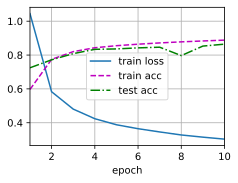

In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # BERT微调所需的（之后将介绍）
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型（在第6章定义）"""

    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和范例数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (metric[0]/metric[2], metric[1]/metric[2], test_acc))
    print(f'loss {metric[0]/metric[2]:.3f}, train acc {metric[1]/metric[2]:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2]*num_epochs/timer.stop():.1f} examples/sec on '
          f'{str(device)}')
num_epochs, lr = 10, 0.9
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())


In [1]:
#alexnet
import torch
from torch import nn
from d2l import torch as d2l
net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 10))
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)
x = torch.rand(size=(1, 1, 224, 224), dtype=torch.float32)
for layer in net:
    x = layer(x)
    print(layer.__class__.__name__,'output shape:\t',x.shape)


Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

loss 0.328, train acc 0.879, test acc 0.880
1374.0 examples/sec on cuda:0


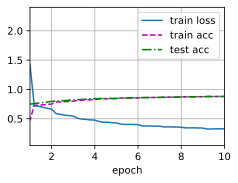

In [5]:
! nvidia-smi


Thu May  9 13:51:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.25                 Driver Version: 536.25       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   40C    P8              15W /  95W |   1462MiB /  6144MiB |     22%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from transformers.models.mamba.modeling_mamba import MambaModel
